In [39]:
from __future__ import unicode_literals, print_function, division
import random
import torch
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import time
from utils import timeSince

from cn_cn_data import get_cn_en_dataloader, to_sentence, cn_vocab, en_vocab


In [40]:
seq_len = 15
max_length = seq_len + 2
batch_size = 1

cn_vocab_size = len(cn_vocab)
en_vocab_size = len(en_vocab)

device = torch.device("cpu")
train_loader, train_dataset = get_cn_en_dataloader(seq_len, batch_size, device)
print('length of train_loader', len(train_loader))

length of train_loader 2207


In [41]:
for i, item in enumerate(train_loader):
    print(item[0].shape, item[1].shape)

    print([idx.item() for idx in item[0]])
    print(to_sentence(item[0], True))
    print([idx.item() for idx in item[1]])
    print(to_sentence(item[1], False))
    break

torch.Size([8, 1]) torch.Size([7, 1])
[2, 19, 670, 669, 17, 18, 5, 3]
['<sos>', '我', '才', '刚', '开', '始', ' 。', '<eos>']
[2, 12, 27, 667, 1790, 5, 3]
['<sos>', 'I', "'m", 'just', 'beginning', '.', '<eos>']


In [42]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.1):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input):
        batch_size = input.size(1)
        hidden = torch.zeros(1, batch_size, self.hidden_size, device=device)
        embedded = self.dropout(self.embedding(input))
        outputs, hidden = self.gru(embedded, hidden)

        return outputs, hidden


In [43]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()

        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Linear(hidden_size, 1, bias=False)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, hidden, encoder_outputs):
        batch_size = encoder_outputs.size(0)
        seq_len = encoder_outputs.size(1)

        hidden = hidden.permute(1, 0, 2)
        # repeat decoder hidden state src_len times, hidden = [batch size, seq len, hidden size]
        hidden = hidden.repeat(1, seq_len, 1)

        # [batch size, seq len, hidden size * 2]
        outputs_cat_hidden = torch.cat((hidden, encoder_outputs), dim=2)

        # energy = [batch size, src len, hidden size]
        energy = torch.tanh(self.attn(outputs_cat_hidden))

        # attention= [batch size, src len]
        attention = self.v(energy).squeeze(2)

        return self.softmax(attention)


In [44]:
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout=0.1):
        super().__init__()
        self.attention = Attention(hidden_size)
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.rnn = nn.GRU(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size * 3, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        # -> [batch size, seq len, hidden size]
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # input = [batch size, 1]
        # hidden = [1, batch size, hidden_size]
        # encoder_outputs = [src len, batch size, hidden_size]

        # embedded = [batch size, hidden_size]
        embedded = self.dropout(self.embedding(input))
        # embedded = [1, batch size, hidden_size]
        embedded = embedded.unsqueeze(0)

        # a = [batch size, src len]
        a = self.attention(hidden, encoder_outputs)
        # a = [batch size, 1, src len]
        a = a.unsqueeze(1)

        # weighted = [batch size, 1, hidden_size]
        weighted = torch.bmm(a, encoder_outputs)

        # weighted = [1, batch size, hidden_size]
        weighted = weighted.permute(1, 0, 2)

        # rnn_input = [1, batch size, hidden_size * 2]
        rnn_input = torch.cat((embedded, weighted), dim=2)

        # output = [seq len, batch size, hidden_size]
        # hidden = [n_layers, batch size, hidden_size]
        output, hidden = self.rnn(rnn_input, hidden)

        # seq len, n layers and n directions will always be 1 in this decoder, therefore:
        # output = [1, batch size, dec hid dim]
        # hidden = [1, batch size, dec hid dim]
        # this also means that output == hidden
        # assert (output == hidden).all()

        # embedded = [batch size, hidden_size]
        embedded = embedded.squeeze(0)
        # output = [batch size, hidden_size]
        output = output.squeeze(0)
        # weighted = [batch size, hidden_size]
        weighted = weighted.squeeze(0)

        # prediction = [batch size, output size]
        prediction = self.out(torch.cat((output, weighted, embedded), dim=1))
        return prediction, hidden, a


In [45]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    target_length = target_tensor.size(1)

    loss = 0

    encoder_outputs, encoder_hidden = encoder(input_tensor)

    decoder_input = input_tensor[0]

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)

            target = target_tensor[di]
            loss += criterion(decoder_output, target)
            decoder_input = target  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze(1).detach()  # detach from history as input

            target = target_tensor[di]
            loss += criterion(decoder_output, target)

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


In [46]:
def trainIters(encoder, decoder, train_loader, print_every=100, plot_every=10, learning_rate=0.0005):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    # criterion = nn.CrossEntropyLoss(ignore_index=cn_vocab['<pad>'])
    n_iters = len(train_loader)

    for iter, data in enumerate(train_loader, 1):
        input_tensor, target_tensor = data

        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    return plot_losses


In [47]:
hidden_size = 256
encoder1 = Encoder(cn_vocab_size, hidden_size).to(device)
decoder1 = Decoder(hidden_size, en_vocab_size).to(device)

train_losses = []
for i in range(10):
    print('--------------epoch %d--------------' % (i + 1))
    losses = trainIters(encoder1, decoder1, train_loader, print_every=200)
    train_losses = train_losses + losses

--------------epoch 1--------------
0m 4s (- 0m 42s) (200 9%) 1.8835
0m 8s (- 0m 38s) (400 18%) 0.0394
0m 12s (- 0m 34s) (600 27%) 0.0187
0m 17s (- 0m 29s) (800 36%) 0.0123
0m 21s (- 0m 25s) (1000 45%) 0.0097
0m 25s (- 0m 21s) (1200 54%) 0.0074
0m 30s (- 0m 17s) (1400 63%) 0.0062
0m 34s (- 0m 13s) (1600 72%) 0.0051
0m 38s (- 0m 8s) (1800 81%) 0.0046
0m 43s (- 0m 4s) (2000 90%) 0.0040
0m 47s (- 0m 0s) (2200 99%) 0.0037
--------------epoch 2--------------
0m 4s (- 0m 43s) (200 9%) 0.0032
0m 8s (- 0m 39s) (400 18%) 0.0031
0m 13s (- 0m 35s) (600 27%) 0.0030
0m 17s (- 0m 31s) (800 36%) 0.0027
0m 22s (- 0m 26s) (1000 45%) 0.0026
0m 26s (- 0m 22s) (1200 54%) 0.0024
0m 31s (- 0m 18s) (1400 63%) 0.0022
0m 35s (- 0m 13s) (1600 72%) 0.0021
0m 40s (- 0m 9s) (1800 81%) 0.0020
0m 44s (- 0m 4s) (2000 90%) 0.0018
0m 49s (- 0m 0s) (2200 99%) 0.0016
--------------epoch 3--------------
0m 4s (- 0m 44s) (200 9%) 0.0017
0m 9s (- 0m 40s) (400 18%) 0.0015
0m 13s (- 0m 36s) (600 27%) 0.0016
0m 18s (- 0m 31s) 

<Figure size 432x288 with 0 Axes>

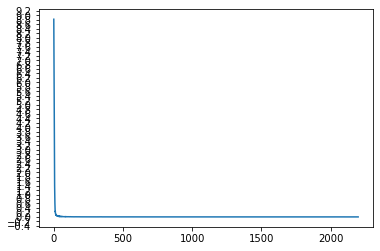

In [48]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)


showPlot(train_losses)


In [49]:
encoder_path = './models/seq2seq6-encoder.pt'
decoder_path = './models/seq2seq6-decoder.pt'


In [50]:
torch.save(encoder1.state_dict(), encoder_path)
torch.save(decoder1.state_dict(), decoder_path)


In [51]:
def evaluate(encoder, decoder, sentence, max_length=seq_len):
    with torch.no_grad():
        input_tensor = train_dataset.tokenize_sentence(sentence, True).unsqueeze(0)
        input_length = input_tensor.size(1)

        encoder_outputs, encoder_hidden = encoder(input_tensor)

        decoder_input = torch.tensor([cn_vocab['<sos>']], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, input_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.data.topk(1)
            decoder_attentions[di] = decoder_attention.squeeze().data
            if topi.item() == en_vocab['<eos>']:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(en_vocab.lookup_token(topi.item()))

            decoder_input = topi.squeeze(1).detach()

        return decoded_words, decoder_attentions[:di + 1]


In [52]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(train_dataset.pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')


In [53]:
encoder2 = Encoder(cn_vocab_size, hidden_size).to(device)
decoder2 = Decoder(hidden_size, en_vocab_size).to(device)

encoder2.load_state_dict(torch.load(encoder_path))
decoder2.load_state_dict(torch.load(decoder_path))


<All keys matched successfully>

In [54]:
evaluateRandomly(encoder2, decoder2)


> 我累得不能再累了。
= I'm as tired as tired can be.


RuntimeError: Sizes of tensors must match except in dimension 2. Expected size 1 but got size 11 for tensor number 1 in the list.

In [ ]:
output_words, attentions = evaluate(encoder2, decoder2, "我不确定。")
output_sentence = ' '.join(output_words)
print(output_sentence)
plt.matshow(attentions.numpy())


In [ ]:
# def showAttention(input_sentence, output_words, attentions):
#     # Set up figure with colorbar
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     cax = ax.matshow(attentions.numpy(), cmap='bone')
#     fig.colorbar(cax)

#     # Set up axes
#     ax.set_xticklabels([''] + list(input_sentence) +
#                        ['<EOS>'], rotation=90)
#     ax.set_yticklabels([''] + output_words)

#     # Show label at every tick
#     ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
#     ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

#     plt.show()


# def evaluateAndShowAttention(input_sentence):
#     output_words, attentions = evaluate(encoder2, decoder2, input_sentence)
#     print('input =', input_sentence)
#     print('output =', ' '.join(output_words))
#     showAttention(input_sentence, output_words, attentions)


# evaluateAndShowAttention("我不确定。")


In [ ]:
cn_vocab.get_stoi()['.']